
## Part 1: Import Libraries and Setup

In [78]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [79]:

param_grid_dt = {
    'feature_selection__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
    'classifier__p': [1, 2]
}

param_grid_lr = {
    'feature_selection__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__max_iter': [1000, 2000]
}


classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'k-NN'),
    (LogisticRegression(random_state=42), param_grid_lr, 'Logistic Regression')
]

## Dataset Loading Functions

### 3.1 Wine Quality Dataset


In [80]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

## Part 4: Manual Grid Search Implementation



In [84]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # Adjust feature selection parameter grid
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            # Ensure k doesn't exceed number of features
            adjusted_param_grid['feature_selection__k'] = [
                k for k in adjusted_param_grid['feature_selection__k']
                if k <= n_features
            ]
            if not adjusted_param_grid['feature_selection__k']:
                adjusted_param_grid['feature_selection__k'] = [min(5, n_features)]

        # Generate all parameter combinations
        param_combinations = []
        param_keys = list(adjusted_param_grid.keys())
        param_values = [adjusted_param_grid[key] for key in param_keys]

        for combination in itertools.product(*param_values):
            param_dict = dict(zip(param_keys, combination))
            param_combinations.append(param_dict)

        print(f"Testing {len(param_combinations)} parameter combinations...")

        # Test each parameter combination
        for i, params in enumerate(param_combinations):

            fold_scores = []

            # Perform cross-validation
            for train_idx, val_idx in cv.split(X_train, y_train):
                # Split data for this fold
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # Build pipeline
                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
                ])

                # Set parameters for current combination
                pipeline.set_params(**params)

                try:
                    # Fit pipeline on training fold
                    pipeline.fit(X_fold_train, y_fold_train)

                    # Predict probabilities on validation fold
                    y_pred_proba = pipeline.predict_proba(X_fold_val)[:, 1]

                    # Compute AUC score for this fold
                    auc_score = roc_auc_score(y_fold_val, y_pred_proba)
                    fold_scores.append(auc_score)

                except Exception as e:
                    # Handle invalid parameter combinations
                    fold_scores.append(0.0)
                    break

            # Compute mean AUC across all folds
            if fold_scores and len(fold_scores) == cv.get_n_splits():
                mean_auc = np.mean(fold_scores)

                # Track best parameter combination
                if mean_auc > best_score:
                    best_score = mean_auc
                    best_params = params.copy()

        # Create the final pipeline for this classifier
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found
        final_pipeline.set_params(**best_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators

## Part 5: Built-in Grid Search Implementation



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [85]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust feature selection parameter grid based on dataset size
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            adjusted_param_grid['feature_selection__k'] = [
                k for k in adjusted_param_grid['feature_selection__k']
                if k <= n_features
            ]
            if not adjusted_param_grid['feature_selection__k']:
                adjusted_param_grid['feature_selection__k'] = [min(5, n_features)]

        # Create pipeline with StandardScaler, SelectKBest, and classifier
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set up StratifiedKFold cross-validation
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Run GridSearchCV with the pipeline and adjusted parameter grid
        grid_search = GridSearchCV(
            pipeline,
            adjusted_param_grid,
            cv=cv_splitter,
            scoring='roc_auc',  # Use AUC as scoring metric
            n_jobs=-1,  # Use all available cores for parallel processing
            verbose=1   # Show progress
        )

        # Fit grid search on training data
        grid_search.fit(X_train, y_train)


        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [86]:
def evaluate_models(X_test, X_train, y_test, y_train, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [87]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, X_train, y_test, y_train, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, X_train, y_test, y_train, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab




################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
Testing 108 parameter combinations...
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__criterion': 'entropy'}
Best cross-validation AUC: 0.7880
--- Manual Grid Search for k-NN ---
Testing 48 parameter combinations...
Best parameters for k-NN: {'feature_selection__k': 5, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan', 'classifier__p': 1}
Best cross-validation AUC: 0.8667
--- Manual G

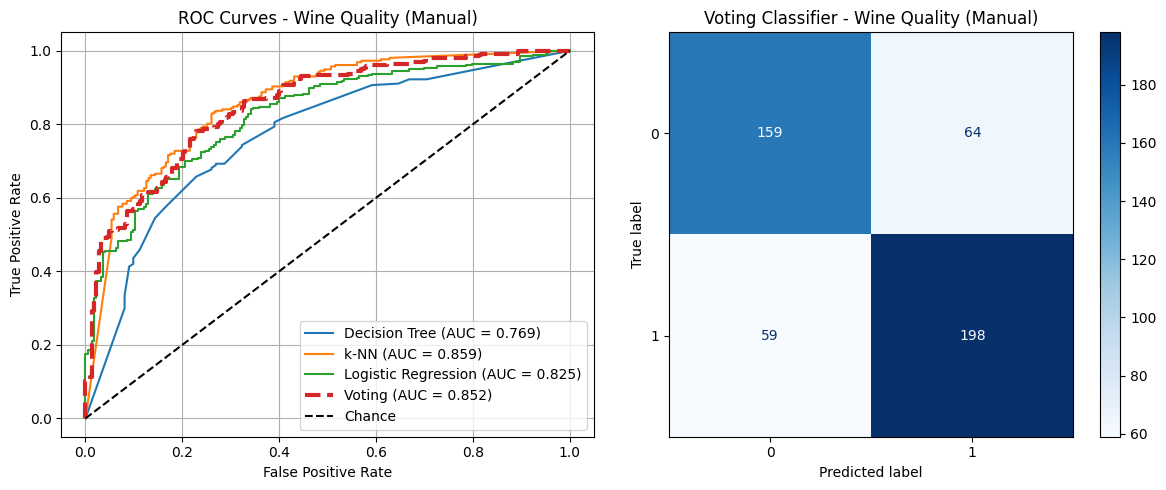


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'feature_selection__k': 5}
Best CV score: 0.7880

--- GridSearchCV for k-NN ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params for k-NN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance', 'feature_selection__k': 5}
Best CV score: 0.8667

--- GridSearchCV for Logistic Regression ---
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params for Logistic Regression: {'classifier__C': 1.0, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 10}
Best CV score: 0.8049

EVALUATING BUILT-IN MODELS FOR WINE

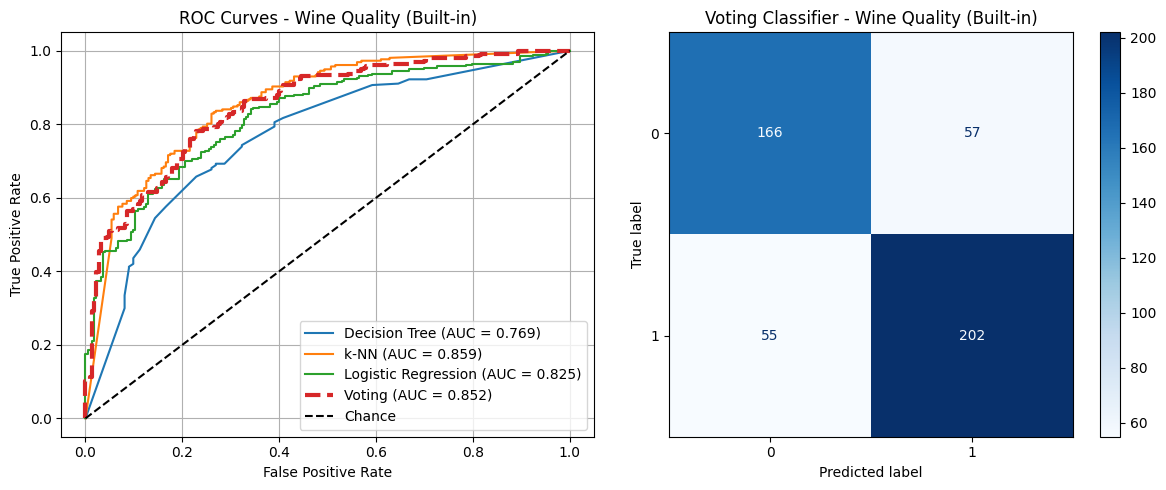


Completed processing for Wine Quality

ALL DATASETS PROCESSED!


In [88]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)